# バックテスト用

input:期間、所持金、使用するルール<br>
output:期間中の所持金の増減具合、図とシャープレシオの値<br>

RSI:パラメータ９
ルールベース
ファットテールを直近の数日でどう変化するかから閾値を設定してトレードルールを変更して避ける

1日で売買を終わらせるように変更

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from trading_rule.RSI_base import trade
from tqdm.notebook import tqdm

In [23]:
#パラメータ
start = '2021-01-01'
end = '2021-10-01'
posses = {'JPY':10000,'USD':0}

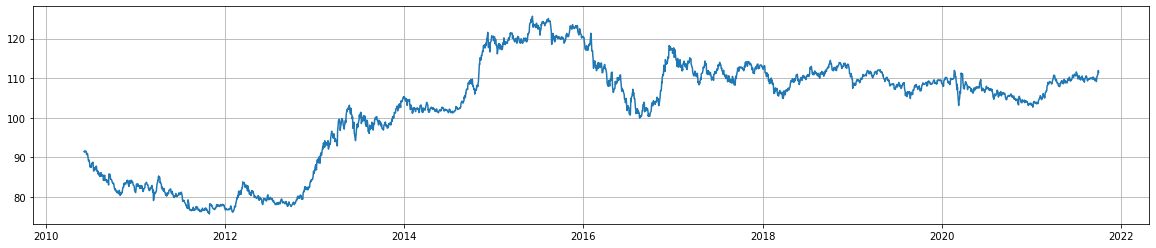

In [24]:
jpy_usd = pd.read_csv('../temp_data/jpy_usd.csv')
jpy_usd.index = pd.to_datetime(jpy_usd['Date'])
del jpy_usd['Date']
jpy_usd = jpy_usd[:end]
plt.figure(figsize=(20,4))
plt.plot(jpy_usd['Close'])
plt.grid()
plt.show()

In [25]:
term_df = jpy_usd[start:end]

In [26]:
term_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,103.225998,103.250000,103.225998,103.225998,103.225998,0
2021-01-04,103.244003,103.244003,102.709999,103.238998,103.238998,0
2021-01-05,103.141998,103.180000,102.671997,103.125000,103.125000,0
2021-01-06,102.699997,103.431000,102.589996,102.678001,102.678001,0
2021-01-07,103.028000,103.950996,102.956001,103.024002,103.024002,0
...,...,...,...,...,...,...
2021-09-27,110.750000,111.055000,110.533997,110.764000,110.764000,0
2021-09-28,110.961998,111.628998,110.936996,110.963997,110.963997,0
2021-09-29,111.513000,111.917000,111.219002,111.528000,111.528000,0


In [27]:
import warnings
warnings.simplefilter('ignore')

pos_trans = []
trade_count = 0
flag = 0 #flagに何か値が入っていないと初めはエラーになる

for i in tqdm(range(len(term_df))):
    
    current_day = str(term_df.index[i])[:10]
    
    # 前日にトレードしてたら今日はその分を売って清算しておく
    if flag=='buy':
        print('trade')
        trade_count+=1
        posses['JPY'] += posses['USD']*term_df.iloc[i,3]
        posses['USD'] = 0

    posses,flag = trade(current_day=str(term_df.index[i])[:10],posses=posses,df=jpy_usd)

    rec = posses.copy()
    rec['current_day'] = str(term_df.index[i])[:10]
    pos_trans.append(rec)
    
pos_trans = pd.DataFrame(pos_trans)

  0%|          | 0/196 [00:00<?, ?it/s]

trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade
trade


In [30]:
pos_trans.index = pd.to_datetime(pos_trans['current_day'])
del pos_trans['current_day']

In [31]:
df = pd.concat([pos_trans,jpy_usd],axis=1)

In [32]:
df['JPY_POS'] = df['USD']*df['Close']+df['JPY']

In [33]:
df

,JPY,USD,Open,High,Low,Close,Adj Close,Volume,JPY_POS
2010-06-07,NaN,NaN,91.570000,92.064003,90.989998,91.515999,91.515999,0,NaN
2010-06-08,NaN,NaN,91.489998,91.906998,90.885002,91.410004,91.410004,0,NaN
2010-06-09,NaN,NaN,91.410004,91.654999,91.040001,91.364998,91.364998,0,NaN
2010-06-10,NaN,NaN,91.320999,91.441002,90.855003,91.308998,91.308998,0,NaN
2010-06-11,NaN,NaN,91.331001,91.755997,91.262001,91.620003,91.620003,0,NaN
...,...,...,...,...,...,...,...,...,...
2021-09-27,9917.925959,0.0,110.750000,111.055000,110.533997,110.764000,110.764000,0,9917.925959
2021-09-28,9917.925959,0.0,110.961998,111.628998,110.936996,110.963997,110.963997,0,9917.925959
2021-09-29,9917.925959,0.0,111.513000,111.917000,111.219002,111.528000,111.528000,0,9917.925959
2021-09-30,9917.925959,0.0,111.921997,112.068001,111.414001,111.935997,111.935997,0,9917.925959


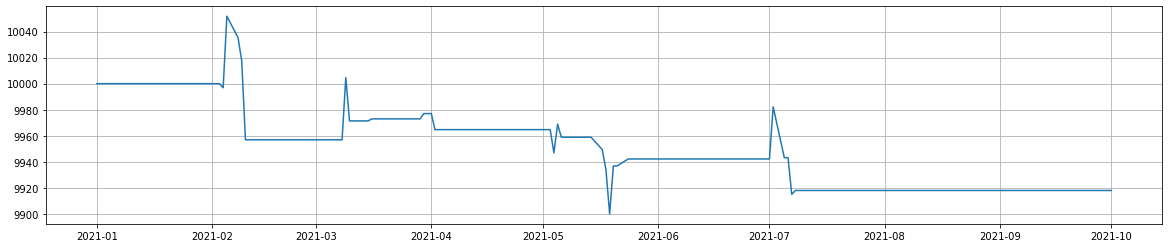

In [34]:
plt.figure(figsize=(20,4))
plt.plot(df['JPY_POS'])
plt.grid()
plt.show()

In [35]:
df = df.dropna()

In [36]:
df['base_pos'] = df['Close']/df.iloc[0,5]*10000

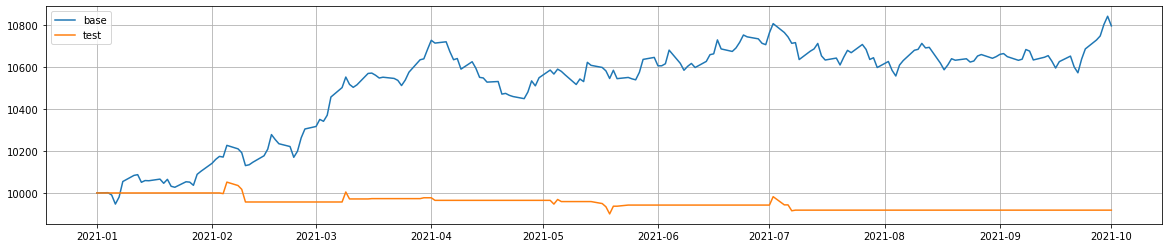

In [37]:
plt.figure(figsize=(20,4))
plt.plot(df['base_pos'])
plt.plot(df['JPY_POS'])
plt.legend(['base','test'])
plt.grid()
plt.show()

所持金をすべて変えるような取引の仕方<br>
売り買いしたタイミング、フラグを描画して、どの局面で売り買いしたか分析できる

実験した内容からモデルへのつなぎこみ

RSIのパラメータ探索期間を1か月~2か月程度
直近当たってないなどでアラート⇒何をもって取引を止めるのが良いか…値動きからモデリング
<br>
30,70ではなく、30から70に行く過程をモデルに含める？

In [15]:
df['JPY_POS'].std()/10000

0.055652886147968296

In [16]:
(df['JPY_POS'].mean()-10000)/10000

-0.06985933896976476

In [17]:
risk = df['JPY_POS'].std()/10000

In [18]:
ret = (df['JPY_POS'].mean()-10000)/10000

In [19]:
base_ret = (df['base_pos'].mean()-10000)/10000

In [20]:
(ret-base_ret)/risk

-0.3769541510321246